***Final Group Project (COMP6105)***<br/>
Kary Ng(p1404599)<br/>
Bryant Ho(p1604811)<br/>
Cyril Fong(p1604918)

Project: **Student Performance Classification Analysis**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Pre-processing

***Load dataset***


In [2]:
# load datasets for two subjects, Math and Portuguese
mat = pd.read_csv("https://raw.githubusercontent.com/dcuti8/data/main/student-mat.csv", sep=';')
por = pd.read_csv("https://raw.githubusercontent.com/dcuti8/data/main/student-por.csv", sep=';')

# merge datasets
df = pd.concat([mat,por])

In [3]:
# rename column labels
df.columns = ['school','sex','age','address','family_size','parents_status','mother_education','father_education',
           'mother_job','father_job','reason','guardian','commute_time','study_time','failures','school_support',
          'family_support','paid_classes','activities','nursery','desire_higher_edu','internet','romantic','family_quality',
          'free_time','go_out','weekday_alcohol_usage','weekend_alcohol_usage','health','absences','period1_score','period2_score','final_score']

In [4]:
# convert final_score to categorical variable # Good:>14 Fair:10-14 Poor:0~10
df['final_grade'] = 'na'
df.loc[(df.final_score > 14) , 'final_grade'] = 'good' 
df.loc[(df.final_score > 10) & (df.final_score <= 14), 'final_grade'] = 'fair' 
df.loc[(df.final_score >= 0) & (df.final_score <= 10), 'final_grade'] = 'poor' 
df.head(5)

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,reason,guardian,commute_time,study_time,failures,school_support,family_support,paid_classes,activities,nursery,desire_higher_edu,internet,romantic,family_quality,free_time,go_out,weekday_alcohol_usage,weekend_alcohol_usage,health,absences,period1_score,period2_score,final_score,final_grade
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,course,mother,2,2,0,yes,no,no,no,yes,yes,no,no,4,3,4,1,1,3,6,5,6,6,poor
1,GP,F,17,U,GT3,T,1,1,at_home,other,course,father,1,2,0,no,yes,no,no,no,yes,yes,no,5,3,3,1,1,3,4,5,5,6,poor
2,GP,F,15,U,LE3,T,1,1,at_home,other,other,mother,1,2,3,yes,no,yes,no,yes,yes,yes,no,4,3,2,2,3,3,10,7,8,10,poor
3,GP,F,15,U,GT3,T,4,2,health,services,home,mother,1,3,0,no,yes,yes,yes,yes,yes,yes,yes,3,2,2,1,1,5,2,15,14,15,good
4,GP,F,16,U,GT3,T,3,3,other,other,home,father,1,2,0,no,yes,yes,no,yes,yes,no,no,4,3,2,1,2,5,4,6,10,10,poor


***Data normalization***

In [5]:
# create dataframe dfd for classification
dfd = df.copy()
dfd = dfd.drop(['final_score'], axis=1)#use final_grade as label

#data normalization
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dfd.final_grade = le.fit_transform(dfd.final_grade)
dfd.school_support = le.fit_transform(dfd.school_support)
dfd.family_support = le.fit_transform(dfd.family_support)
dfd.paid_classes = le.fit_transform(dfd.paid_classes)
dfd.activities = le.fit_transform(dfd.activities)
dfd.nursery = le.fit_transform(dfd.nursery)
dfd.desire_higher_edu = le.fit_transform(dfd.desire_higher_edu)
dfd.internet = le.fit_transform(dfd.internet)
dfd.romantic = le.fit_transform(dfd.romantic)
dfd.school = le.fit_transform(dfd.school)
dfd.sex = le.fit_transform(dfd.sex)
dfd.address = le.fit_transform(dfd.address)
dfd.family_size = le.fit_transform(dfd.family_size)
dfd.parents_status = le.fit_transform(dfd.parents_status)
dfd.mother_job = le.fit_transform(dfd.mother_job)
dfd.father_job = le.fit_transform(dfd.father_job)
dfd.reason = le.fit_transform(dfd.reason)
dfd.guardian = le.fit_transform(dfd.guardian)

dfd.head(5)

,school,sex,age,address,family_size,parents_status,mother_education,father_education,mother_job,father_job,reason,guardian,commute_time,study_time,failures,school_support,family_support,paid_classes,activities,nursery,desire_higher_edu,internet,romantic,family_quality,free_time,go_out,weekday_alcohol_usage,weekend_alcohol_usage,health,absences,period1_score,period2_score,final_grade
0,0,0,18,1,0,0,4,4,0,4,0,1,2,2,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,2
1,0,0,17,1,0,1,1,1,0,2,0,0,1,2,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,2
2,0,0,15,1,1,1,1,1,0,2,2,1,1,2,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,2
3,0,0,15,1,0,1,4,2,1,3,1,1,1,3,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,1
4,0,0,16,1,0,1,3,3,2,2,1,0,1,2,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,2


In [6]:
#separate the input X and output label y
X = dfd.drop('final_grade',axis=1)
y = dfd.final_grade

# see total number of features
print(X.shape)

(1044, 32)


***Feature selection***

 1) parents_status                 0.004353
 2) internet                       0.005972
 3) family_support                 0.007028
 4) nursery                        0.007211
 5) address                        0.007212
 6) romantic                       0.007585
 7) sex                            0.007594
 8) family_size                    0.007642
 9) activities                     0.008102
10) school                         0.008374
11) school_support                 0.008449
12) desire_higher_edu              0.009486
13) paid_classes                   0.009572
14) guardian                       0.009913
15) weekday_alcohol_usage          0.011837
16) commute_time                   0.013194
17) family_quality                 0.014380
18) reason                         0.014859
19) study_time                     0.015514
20) father_job                     0.015810
21) weekend_alcohol_usage          0.016744
22) mother_job                     0.017156
23) free_time                   

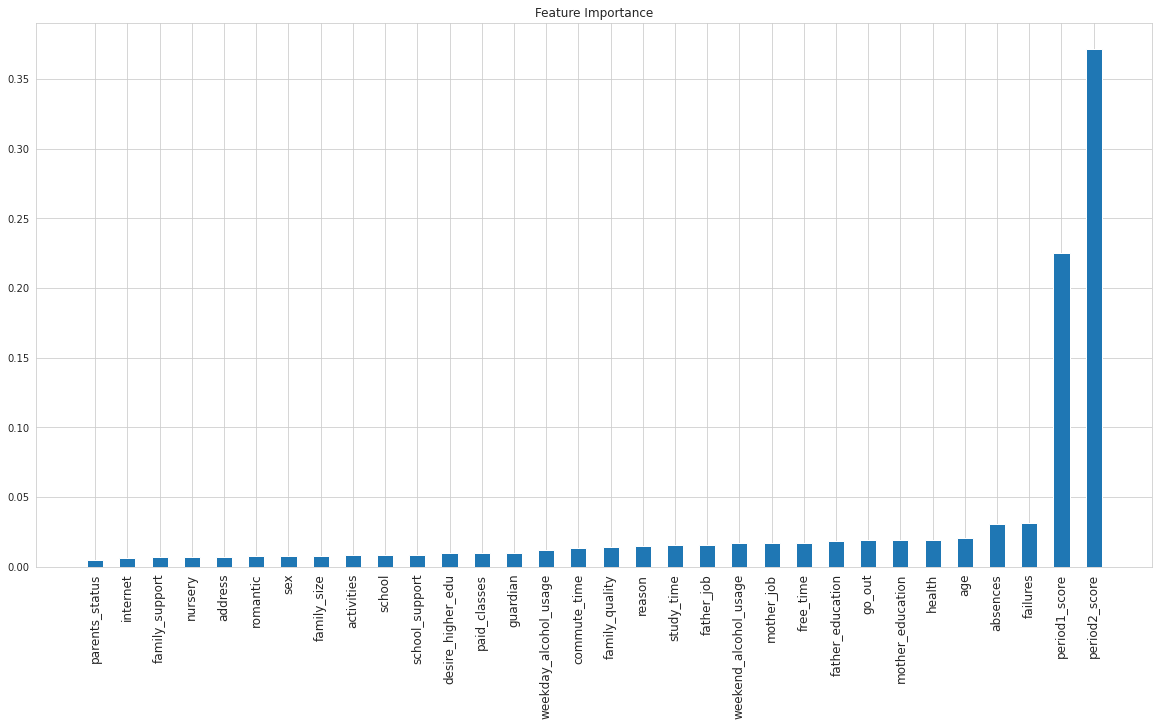

In [7]:
# random forest for feature importance on a classification problem
from sklearn.ensemble import RandomForestClassifier

# define the model
model = RandomForestClassifier(n_estimators=500,criterion="entropy",random_state=0)
# fit the model
model.fit(X, y)
# get importance
importances = model.feature_importances_

#sort importance feature
indices = np.argsort(importances)
# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]
for f in range(X.shape[1]):
  print("%2d) %-*s %f" % (f + 1, 30, names[f], importances[indices[f]]))

# Barplot: Add bars
plt.figure(figsize=(20,10))
plt.bar(range(X.shape[1]), importances[indices],width=0.5)
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]),names, rotation=90, fontsize = 12)
#from here we cam see that absences is the important features for determining the grades of students

plt.title("Feature Importance")
plt.show()

**Picking those important features from data**

In [8]:
print("Original number of features:", len(X.columns[:]))
#get the importance feature
top_features = X.columns[:][importances>0.010]
print("After feature selection number of features:", len(top_features))
#remove the unimportant feature from data 
X_top = X[top_features]
X_top.head(5)

Original number of features: 32
After feature selection number of features: 18


,age,mother_education,father_education,mother_job,father_job,reason,commute_time,study_time,failures,family_quality,free_time,go_out,weekday_alcohol_usage,weekend_alcohol_usage,health,absences,period1_score,period2_score
0,18,4,4,0,4,0,2,2,0,4,3,4,1,1,3,6,5,6
1,17,1,1,0,2,0,1,2,0,5,3,3,1,1,3,4,5,5
2,15,1,1,0,2,2,1,2,3,4,3,2,2,3,3,10,7,8
3,15,4,2,1,3,1,1,3,0,3,2,2,1,1,5,2,15,14
4,16,3,3,2,2,1,1,2,0,4,3,2,1,2,5,4,6,10


***Split dataset into train and test set***

In [9]:
#split dataset into train and test set
from sklearn.model_selection import train_test_split
print('whole dataset: ',X_top.shape)
X_train,X_test,y_train,y_test=train_test_split(X_top,y,test_size=0.3)
print('traning set: ',X_train.shape)
print('testing set: ',X_test.shape)

whole dataset:  (1044, 18)
traning set:  (730, 18)
testing set:  (314, 18)


**Classification**

**1.Decision Tree Classification**

In [10]:
# find the optimal # of minimum samples leaf
from sklearn.tree import DecisionTreeClassifier

msl=[]
for i in range(1,len(list(X_train))):
    tree = DecisionTreeClassifier(min_samples_leaf=i)
    t= tree.fit(X_train, y_train)
    ts=t.score(X_test, y_test)
    msl.append(ts)
msl = pd.Series(msl)
msl.where(msl==msl.max()).dropna()

8    0.878981
dtype: float64

In [20]:
tree = DecisionTreeClassifier(min_samples_leaf=8)
t= tree.fit(X_train, y_train)
print("Decisioin Tree Model Score" , ":" , t.score(X_train, y_train) , "," , 
      "Cross Validation Score" ,":" , t.score(X_test, y_test))

Decisioin Tree Model Score : 0.9041095890410958 , Cross Validation Score : 0.8694267515923567


**2.Random Forest Classification**

In [12]:
from sklearn.ensemble import RandomForestClassifier

ne=[]
for i in range(1,len(list(X_train))):
    forest = RandomForestClassifier()
    f = forest.fit(X_train, y_train)
    fs = f.score(X_test, y_test)
    ne.append(fs)
ne = pd.Series(ne)
ne.where(ne==ne.max()).dropna()

1    0.88535
3    0.88535
5    0.88535
8    0.88535
dtype: float64

In [21]:
from sklearn.ensemble import RandomForestClassifier

ne=[]
for i in range(1,len(list(X_train))):
    forest = RandomForestClassifier(n_estimators=8, min_samples_leaf=i)
    f = forest.fit(X_train, y_train)
    fs = f.score(X_test, y_test)
    ne.append(fs)
ne = pd.Series(ne)
ne.where(ne==ne.max()).dropna()

14    0.888535
dtype: float64

In [22]:
forest = RandomForestClassifier(n_estimators=8, min_samples_leaf=14)
f = forest.fit(X_train, y_train)
print("Raondom Forest Model Score" , ":" , f.score(X_train, y_train) , "," ,
      "Cross Validation Score" ,":" , f.score(X_test, y_test))

Raondom Forest Model Score : 0.8890410958904109 , Cross Validation Score : 0.8789808917197452


**3.Support Vector Classification**

In [23]:
from sklearn.svm import SVC
svc = SVC()
s= svc.fit(X_train, y_train)
print("SVC Model Score" , ":" , s.score(X_train, y_train) , "," ,
      "Cross Validation Score" ,":" , s.score(X_test, y_test))

SVC Model Score : 0.8835616438356164 , Cross Validation Score : 0.8662420382165605


**4.Logistic Regression**

In [24]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial', solver='newton-cg',fit_intercept=True)

from sklearn.feature_selection import SelectKBest, chi2

ks=[]
for i in range(1,len(list(X_train))):
    sk = SelectKBest(chi2, k=i)
    x_new = sk.fit_transform(X_train,y_train)
    x_new_test=sk.fit_transform(X_test,y_test)
    l = lr.fit(x_new, y_train)
    ll = l.score(x_new_test, y_test)
    ks.append(ll)  
    
ks = pd.Series(ks)
ks = ks.reindex(list(range(1,len(list(X_train)))))
ks

1     0.872611
2     0.875796
3     0.869427
4     0.882166
5     0.885350
6     0.891720
7     0.891720
8     0.859873
9     0.850318
10    0.850318
11    0.869427
12    0.859873
13    0.866242
14    0.875796
15    0.875796
16    0.859873
17         NaN
dtype: float64

Showing the correlation of number of features used and prediction accuracy

Text(0, 0.5, 'Prediction Accuracy')

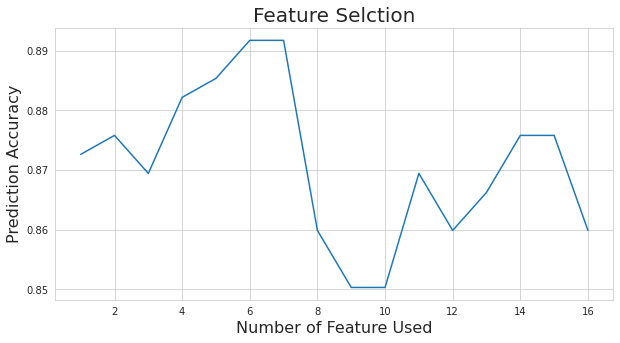

In [25]:
plt.figure(figsize=(10,5))
ks.plot.line()
plt.title('Feature Selction', fontsize=20)
plt.xlabel('Number of Feature Used', fontsize=16)
plt.ylabel('Prediction Accuracy', fontsize=16)

In [26]:
ks.where(ks==ks.max()).dropna()

6    0.89172
7    0.89172
dtype: float64

In [27]:
# final model
sk = SelectKBest(chi2, k=7)
x_new = sk.fit_transform(X_train,y_train)
x_new_test=sk.fit_transform(X_test,y_test)
lr = lr.fit(x_new, y_train)
print("Logistic Regression Model Score" , ":" , lr.score(x_new, y_train) , "," ,
      "Cross Validation Score" ,":" , lr.score(x_new_test, y_test))

Logistic Regression Model Score : 0.8917808219178082 , Cross Validation Score : 0.89171974522293
